# 📃 Solution for Exercise M2.01

The aim of this exercise is to make the following experiments:

* train and test a support vector machine classifier through cross-validation;
* study the effect of the parameter gamma of this classifier using a
  validation curve;
* use a learning curve to determine the usefulness of adding new samples in
  the dataset when building a classifier.

To make these experiments we will first load the blood transfusion dataset.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">If you want a deeper overview regarding this dataset, you can refer to the
Appendix - Datasets description section at the end of this MOOC.</p>
</div>

In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("../datasets/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

We will use a support vector machine classifier (SVM). In its most simple
form, a SVM classifier is a linear classifier behaving similarly to a logistic
regression. Indeed, the optimization used to find the optimal weights of the
linear model are different but we don't need to know these details for the
exercise.

Also, this classifier can become more flexible/expressive by using a so-called
kernel that makes the model become non-linear. Again, no requirement regarding
the mathematics is required to accomplish this exercise.

We will use an RBF kernel where a parameter `gamma` allows to tune the
flexibility of the model.

First let's create a predictive pipeline made of:

* a [`sklearn.preprocessing.StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
  with default parameter;
* a [`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
  where the parameter `kernel` could be set to `"rbf"`. Note that this is the
  default.

In [2]:
# solution
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC())

Evaluate the generalization performance of your model by cross-validation with
a `ShuffleSplit` scheme. Thus, you can use
[`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)
and pass a
[`sklearn.model_selection.ShuffleSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html)
to the `cv` parameter. Only fix the `random_state=0` in the `ShuffleSplit` and
let the other parameters to the default.

In [3]:
# solution
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.018266,0.002987,0.680000
1,0.018917,0.004833,0.746667
2,0.020283,0.005589,0.786667
3,0.026031,0.004385,0.800000
4,0.018653,0.005042,0.746667
5,0.020375,0.004830,0.786667
6,0.020482,0.002428,0.800000
7,0.015194,0.003665,0.826667
8,0.016575,0.003135,0.746667
9,0.021116,0.003615,0.733333


In [4]:
print(
    f"Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f}"
)

Accuracy score of our model:
0.765 ± 0.043


As previously mentioned, the parameter `gamma` is one of the parameters
controlling under/over-fitting in support vector machine with an RBF kernel.

Evaluate the effect of the parameter `gamma` by using the
[`sklearn.model_selection.validation_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html)
function. You can leave the default `scoring=None` which is equivalent to
`scoring="accuracy"` for classification problems. You can vary `gamma` between
`10e-3` and `10e2` by generating samples on a logarithmic scale with the help
of `np.logspace(-3, 2, num=30)`.

Since we are manipulating a `Pipeline` the parameter name will be set to
`svc__gamma` instead of only `gamma`. You can retrieve the parameter name
using `model.get_params().keys()`. We will go more into detail regarding
accessing and setting hyperparameter in the next section.

In [5]:
# solution
import numpy as np
from sklearn.model_selection import validation_curve

gammas = np.logspace(-3, 2, num=30)
param_name = "svc__gamma"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=gammas, cv=cv,
    n_jobs=2)

Plot the validation curve for the train and test scores.

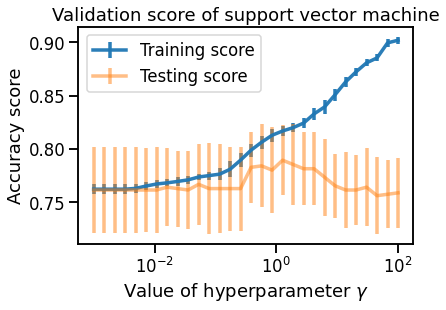

In [6]:
# solution
import matplotlib.pyplot as plt

plt.errorbar(
    gammas,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    gammas,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend()

plt.xscale("log")
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score of support vector machine")

Looking at the curve, we can clearly identify the over-fitting regime of the
SVC classifier when `gamma > 1`. The best setting is around `gamma = 1` while
for `gamma < 1`, it is not very clear if the classifier is under-fitting but
the testing score is worse than for `gamma = 1`.

Now, you can perform an analysis to check whether adding new samples to the
dataset could help our model to better generalize. Compute the learning curve
(using [`sklearn.model_selection.learning_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html))
by computing the train and test scores for different training dataset size.
Plot the train and test scores with respect to the number of samples.

In [8]:
# solution
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1, num=10)
results = learning_curve(
    model, data, target, train_sizes=train_sizes, cv=cv, n_jobs=2)
train_size, train_scores, test_scores = results[:3]

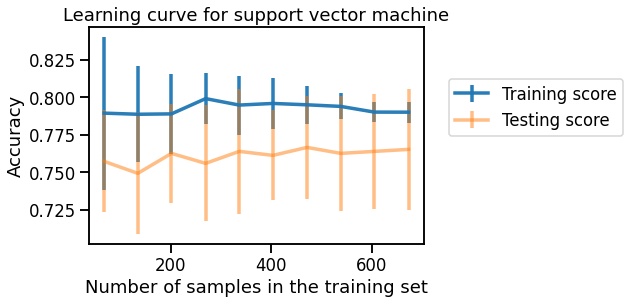

In [9]:
plt.errorbar(
    train_size,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    train_size,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve for support vector machine")

We observe that adding new samples to the training dataset does not seem to
improve the training and testing scores. In particular, the testing score
oscillates around 76% accuracy. Indeed, ~76% of the samples belong to the
class `"not donated"`. Notice then that a classifier that always predicts the
`"not donated"` class would achieve an accuracy of 76% without using any
information from the data itself. This can mean that our small pipeline is not
able to use the input features to improve upon that simplistic baseline, and
increasing the training set size does not help either.

It could be the case that the input features are fundamentally not very
informative and the classification problem is fundamentally impossible to
solve to a high accuracy. But it could also be the case that our choice of
using the default hyperparameter value of the `SVC` class was a bad idea, or
that the choice of the `SVC` class is itself sub-optimal.

Later in this MOOC we will see how to better tune the hyperparameters of a
model and explore how to compare the predictive performance of different model
classes in a more systematic way.